In [61]:
import re, orodja
import pandas as pd
import matplotlib.pyplot as plt
file = 'osu_index.txt'
aux_file = 'data-auxf.txt'
page = 'https://osu.ppy.sh/beatmapsets?sort=difficulty_desc&s=ranked'
word_file = 'words.txt'
word_page = 'https://en.wikipedia.org/wiki/Most_common_words_in_English'

## Auxilary code to make a file if one doesn't already exist

In [62]:
def create_files(files=[file, aux_file, 'data.json', 'data.csv']):
    for f in files:
        try:
            a = open(f, 'x')
            a.close()
        except:
            continue

Regex here

In [63]:
curr_re = r'\{"beatmapsets":\[(.*?)\]\}\]'
data_block_re = r'\{.*?\}\]\}'
data_re = re.compile(
    r'\{'
    r'"artist":(?P<artist>.*?)?,.*?,'
    r'"creator":(?P<creator>.*)?,' 
    r'"favourite_count":(?P<fav_count>\d*)?,.*?,'
    r'"id":(?P<id>\d*)?,.*?,'
    r'"play_count":(?P<play_count>\d*)?,.*?,'
    r'"status":(?P<status>.*)?,'
    r'"title":(?P<title>.*?)?,.*?,'
    r'"bpm":(?P<bpm>\d*)?,.*?'
    r'"tags":"(?P<tags>.*?)?",'
    r'"beatmaps":\[(?P<beatmapset>.*?)?\]'
    r'\}',
    flags=re.DOTALL
)

beatmapset_re = re.compile(
    r'\{.*?\}',
    flags=re.DOTALL
)

bmaux_re = re.compile(
    r'[^\\]',
    flags=re.DOTALL
)

beatmap_re = re.compile(
    r'\{.*?,'
    r'"difficulty_rating":(?P<difficulty_rating>.*?),'
    r'"id":(?P<id>\d*?),.*?,'
    r'"total_length":(?P<map_len>\d*?),.*?,'
    r'"accuracy":(?P<accuracy>.*?),'
    r'"ar":(?P<approach_rate>.*?),'
    r'"bpm":(?P<beatmap_bpm>\d*?),.*?,'
    r'"passcount":(?P<passcount>\d*?),'
    r'"playcount":(?P<playcount>\d*?),.*?,'
    r'"max_combo":(?P<max_combo>\d*?)\}',
    flags=re.DOTALL
)

## Separate code snippets here

In [64]:
def scrape(fin: str, out: str) -> None:
    regex = re.compile(curr_re, flags=re.DOTALL) #re.DOTALL postav piko na vse, vkljucno s novo vrstico
    with open(fin) as f:
        stuff = f.read()
        with open(out, 'w', encoding='UTF8')as o:
            print(re.findall(regex, stuff), file=o)

In [65]:
def make_blocks(filename: str) -> list:
    l = []
    with open(filename) as f:
        stuff = f.read()
    regex = re.compile(data_block_re, flags=re.DOTALL)
    for block in re.findall(regex, stuff):
        l.append(block)
    return l

In [66]:
def scrape_block(block: str) -> dict:
    if not block: return {}
    map = data_re.search(block).groupdict()
    map['fav_count'] = int(map.get('fav_count', 0))
    map['id'] = int(map.get('id', 0))
    map['play_count'] = int(map.get('play_count', 0))
    map['bpm'] = int(map['bpm']) 
    map['tags'] = map['tags'].split(' ')
    # map['beatmapset'] = scrape_beatmaps(map.get('beatmapset', ''))
    beatmapsset_string =  map.get('beatmapset', '')
    l = []
    for match in re.findall(r'\{.*?\}', beatmapsset_string):
        l.append(beatmap_re.search(match).groupdict())
    map['beatmapset'] = l
    return map

In [67]:
def error_check(block: str) -> bool: #eni so prazni iz nekga razloga
    try:
        scrape_block(block)
        return True
    except:
        print('Empty match!')
        return False

Replaces (if \_\_name__ == '\_\_main__')

In [68]:
create_files()
orodja.shrani_spletno_stran(page, file, vsili_prenos=True)
scrape(file, aux_file)
data_blocks = make_blocks(aux_file)
data = []
for i, block in enumerate(data_blocks):
    if not error_check(block):
        print(i)
        continue
    data.append(scrape_block(block))
orodja.zapisi_json(data, 'data.json')
data_format = [
    'id', 
    'title', 
    'creator',
    'artist', 
    'fav_count', 
    'play_count', 
    'bpm', 
    'status', 
    'tags', 
    'beatmapset'
    ]
orodja.zapisi_csv(data, data_format, 'data.csv')

Empty match!
7
Empty match!
11
Empty match!
21
Empty match!
43
Empty match!
45


From here is more code for data points and analysis

In [69]:
def filter_tags(l:list[str]) -> list[str]: #tole je nazalost treba ker unfiltered list item je ubistvu samo en doug string
    tags_re = re.compile(
        r'\w+',
        re.DOTALL
    )
    s = re.findall(tags_re, l)
    for i, chars in enumerate(s):
        if chars == '':
            s.pop(i)
    return s

we're gonna need a little bit of extra code to sort through the raw unicode characters

In [70]:
def unicode_checker(s:str) -> bool:
    uni_re = re.compile(r'u[\d\w]{4}', flags=re.DOTALL)
    if re.match(uni_re, s): return True
    return False

In [71]:
def sort_tags(s: pd.Series, reverse=True) -> list[tuple]:
    tags_filtered = s.apply(filter_tags)
    u = {}
    for tags in tags_filtered:
        for tag in tags: #ta dvojn for loop je zelo fajn
            if unicode_checker(tag): continue
            if len(tag) <= 2: continue
            if u == {} or tag not in u.keys():
                u[tag] = 1
            else:
                u[tag] += 1
    return sorted(u.items(), key=lambda x:x[1], reverse=reverse)

Another (if \_\_name__ == '__main\_\_') part

In [79]:
df = pd.read_csv('data.csv')
subtable = df[['id', 'title', 'tags']]
all_tags_sorted = sort_tags(df.tags)
all_tags_sorted_table = pd.DataFrame(all_tags_sorted, columns=['Tag' , 'Appearances'])
# all_tags_sorted_table.head(20).plot.bar(x='Tag', y='Appearances')

In [74]:
orodja.shrani_spletno_stran(word_page, word_file, vsili_prenos=True)
word_re = r'<a href="https://en\.wiktionary\.org/wiki/(.*?)#English" class="extiw" title="wikt:(.*?)">(?P<word>.*?)</a>'
def common_words (filename) -> list:
    l = []
    with open(filename) as f:
        stuff = f.read()
    regex = re.compile(word_re, flags=re.DOTALL)
    for word in re.findall(regex, stuff):
        l.append(word[0])
    return l 
words = common_words('words.txt')

In [75]:
def filter_common_words(data: list, word_list=words):
    r = []
    for tag in data:
        if tag[0] not in word_list:
            r.append(tag)
    return r
tags_sorted_filtered = pd.DataFrame(filter_common_words(all_tags_sorted),columns=['Tag' , 'Appearances'])

<AxesSubplot: xlabel='Tag'>

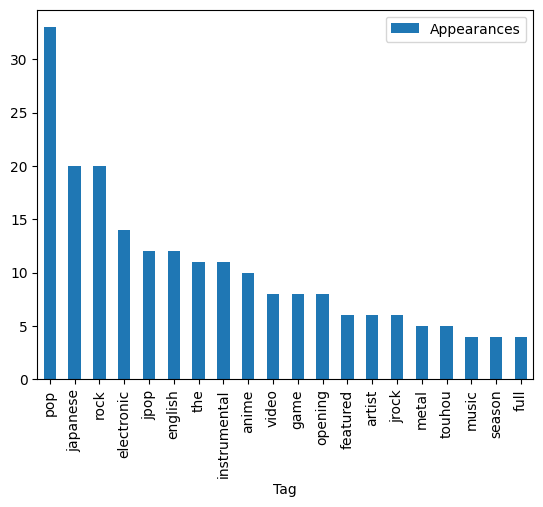

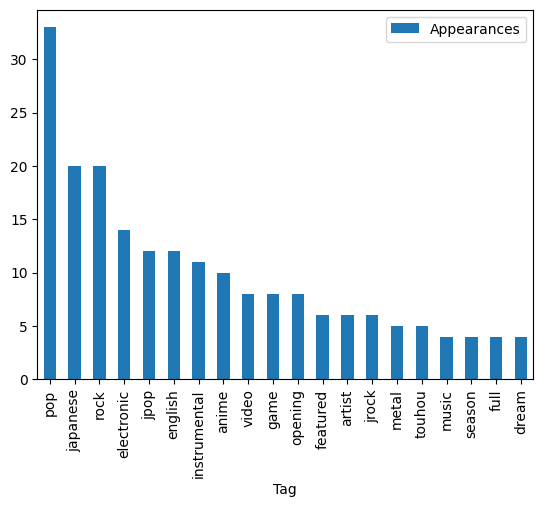

In [80]:
all_tags_sorted_table.head(20).plot.bar(x='Tag', y='Appearances') # Tale ne dela
tags_sorted_filtered.head(20).plot.bar(x='Tag', y='Appearances')

<AxesSubplot: xlabel='title'>

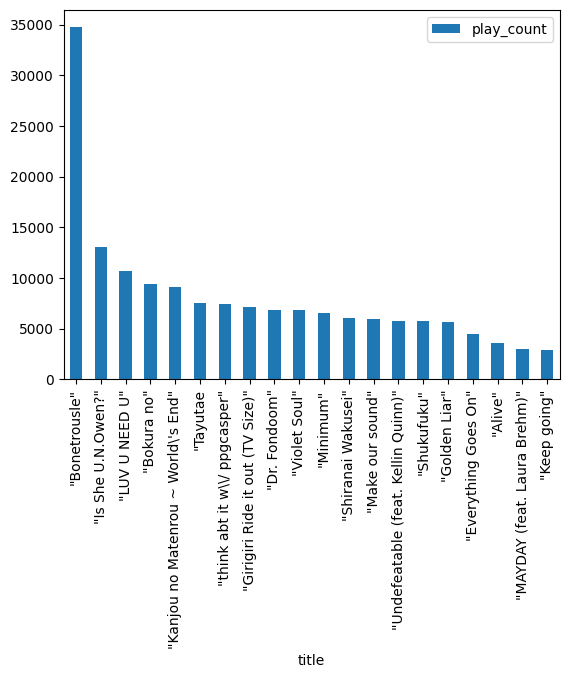

In [89]:
subtable_by_playcount = df[['id', 'title', 'play_count']].sort_values('play_count', ascending=False)
subtable_by_playcount.head(20).plot.bar(x='title', y='play_count')

Give rankings to the sortad by playcount table, to try and predict a ranking

In [145]:
# beatmaps_ranked_by_playcount = subtable_by_playcount.reset_index().drop('index', axis= 1)
def grab_index_from_title(df: pd.DataFrame, title: str):
    for item in df.iterrows():
        if title in item[1]:
            return item[0]
def predict_rank(df: pd.DataFrame, title: str):
    pass
grab_index_from_title(subtable_by_playcount, '"Bonetrousle"')

This next one is of ***FIGURATIVE*** nature, caution is advised

Run this snippet only if you want to _spawn satan himself onto this world_, otherwise it's unnecessary

In [73]:
%%script false --no-raise-error
figure1, ax1 = plt.subplots()
ax1.pie(all_tags_sorted_table.Appearances, labels=all_tags_sorted_table.Tag, autopct='%1.1f%%', shadow=False, startangle=0)
ax1.axis('equal')
plt.title('The Antichrist')
#i'm submitting  this one just because of how cursed it is head(20)
plt.show()

Here we begin with the naive Bayes algorithm : scrape the 100 most common english words. Filter the words if they appear in the common ones, such as 'the', 'no', and so on. With the rest try to predict which beatmaps are most played by their tags. I doubt that will work just because of the sheer amount of tags as well as those that duplicate, but maybe we get an interesting result.

### Random stuff

In [78]:
tags_sorted_filtered

,Tag,Appearances
0,pop,33
1,japanese,20
2,rock,20
3,electronic,14
4,jpop,12
...,...,...
665,symphonic,1
666,erum,1
667,nagi,1
668,elm,1


In [148]:
for item in subtable_by_playcount.head(20).iterrows():
    print(item[1])
subtable_by_playcount[['id', 'title', 'play_count', 'tags']]

id                  1916289
title         "Bonetrousle"
play_count            34727
Name: 36, dtype: object
id                       1779511
title         "Is She U.N.Owen?"
play_count                 13062
Name: 42, dtype: object
id                   1910029
title         "LUV U NEED U"
play_count             10697
Name: 13, dtype: object
id                1918427
title         "Bokura no"
play_count           9373
Name: 16, dtype: object
id                                        1871215
title         "Kanjou no Matenrou ~ World\'s End"
play_count                                   9145
Name: 26, dtype: object
id             1904026
title         "Tayutae
play_count        7573
Name: 29, dtype: object
id                                  1773437
title         "think abt it w\\/ ppgcasper"
play_count                             7456
Name: 39, dtype: object
id                                     1863644
title         "Girigiri Ride it out (TV Size)"
play_count                             

KeyError: "['tags'] not in index"

In [138]:
df

,id,title,creator,artist,fav_count,play_count,bpm,status,tags,beatmapset
0,1923942,"""happy palette""","""Muse Dash""","""Aitsuki Nakuru""",8,81,170,"""ranked""","['ml-ysg', 'madosoft', '\\\\u307e\\\\u3069\\\\...","[{'difficulty_rating': '4.43', 'id': '3971763'..."
1,1892271,"""Undefeatable (feat. Kellin Quinn)""","""Voli""","""Tomoya Ohtani""",67,5784,200,"""ranked""","['synitri', 'infinite', 'giganto', 'boss', 'sh...","[{'difficulty_rating': '6.72', 'id': '3898949'..."
2,1902848,"""Cinnamon Girl""","""Superstore""","""Lana Del Rey""",29,911,72,"""ranked""","['psychedelic', 'trip', 'hop', 'triphop', 'pop...","[{'difficulty_rating': '3.31', 'id': '3923062'..."
3,1899965,"""Shall we Dance?""","""Antipole""","""ReoNa""",22,438,80,"""ranked""","['symmatrix-', 'doctortetravoid', 'shadows', '...","[{'difficulty_rating': '4.16', 'id': '3916282'..."
4,1723410,"""They\'re again&again""","""katacheh""","""t+pazolite & Nanahira""",39,1022,333,"""loved""","[""screamin\\'"", 'showcase', 'svs', 'slider', '...","[{'difficulty_rating': '5.2', 'id': '3522149',..."
5,1912643,"""Chaotic Prayers""","""Hana Hayashi""","""Null Specification""",5,176,200,"""ranked""","['electronic', 'japanese', 'psycore', 'jcore',...","[{'difficulty_rating': '6.77', 'id': '3945382'..."
6,1834058,"""Minimum""","""Reiszen""","""MIMI feat. wanko""",42,6568,202,"""ranked""","['japanese', 'pop', 'jpop', 'j-pop', '\\\\u308...","[{'difficulty_rating': '5.26', 'id': '3765215'..."
7,1900494,"""Merkabah""","""Ghouru""","""Persefone""",37,734,160,"""ranked""","['itswinter', 'metanoia', 'progressive', 'melo...","[{'difficulty_rating': '7.01', 'id': '3917473'..."
8,1923526,"""Detonate""","""DeviousPanda""","""G2",33,2910,93,"""ranked""","['rock', 'english', 'pbc', 'realazy', 'real', ...","[{'difficulty_rating': '3.49', 'id': '3970837'..."
9,1873680,"""You spin my world""","""Kyouren""","""happy30""",23,2330,196,"""ranked""","['happythirsty', 'happythirty', 'jordi', 'van'...","[{'difficulty_rating': '4.84', 'id': '3855504'..."
